<h1><u><center>Sentiment Analysis of Movie Reviews </center></u></h1>

Through this notebook, we will be analysing different movie reviews and identifying the sentiment of the review and thereby classify if the review for the movie is either positive or negative.

## 1. Importing the necessary modules.

In [1]:
import numpy as np
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


## Reading the Datasets and Analysing its structure.

In [2]:
trainset = pd.read_csv(r'/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
testset = pd.read_csv(r'/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies = pd.read_csv(r'/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

In [3]:
trainset.head()


,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [4]:
testset.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [5]:
trainset.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [6]:
movies.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [7]:
print("The Training Set has {row} rows and {col} columns.".format(row = trainset.shape[0],col = trainset.shape[1]))
print("The test set has {row} rows and {col} columns.".format(row = testset.shape[0],col = testset.shape[1]))

The Training Set has 162758 rows and 5 columns.
The test set has 55315 rows and 4 columns.


In [8]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [9]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


The movies dataset servers to provide metadata for the respective training and test reviews. Out of which, the relevant columns that can be used to possibly explore the reviews 

In [11]:
movies.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

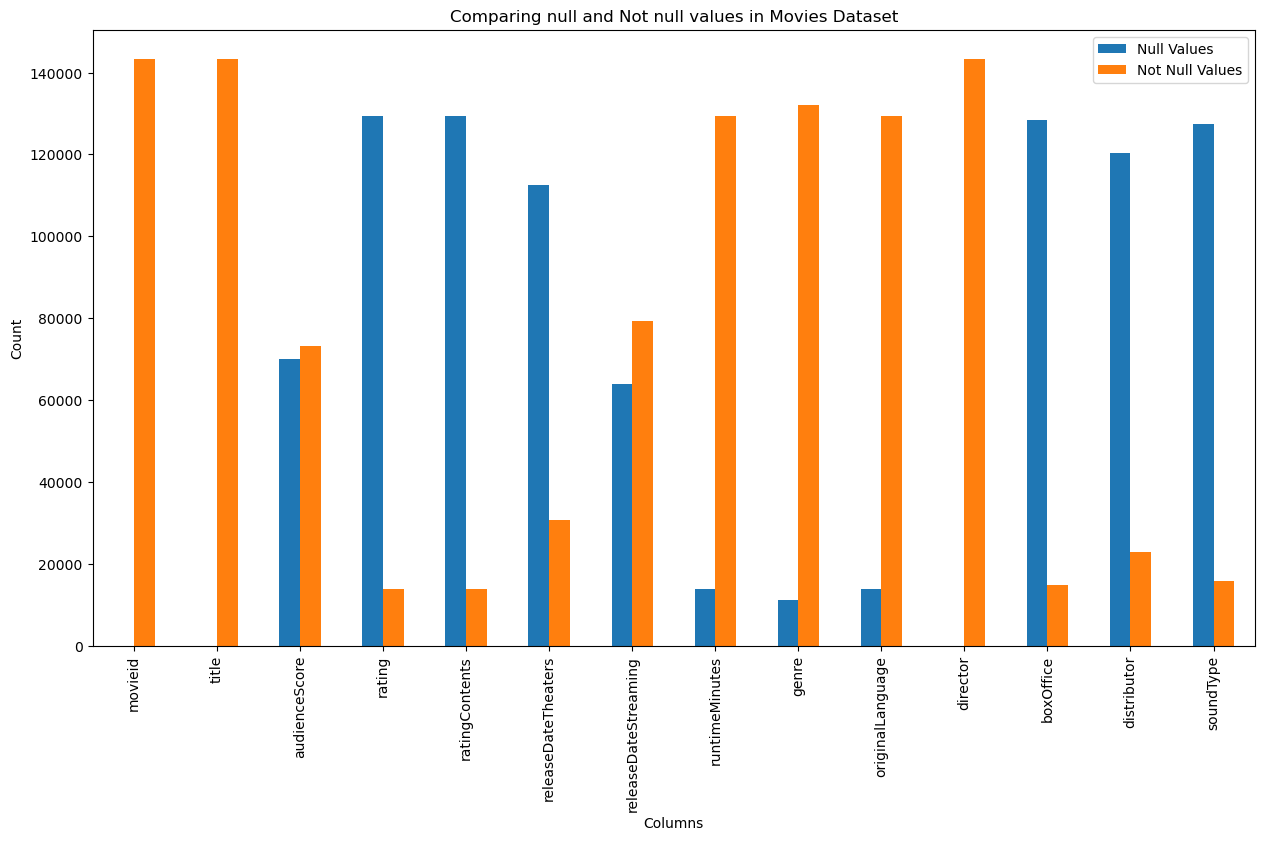

In [12]:
col_movies = movies.columns.tolist()

null_values = []
not_null_values = []

for null in movies.isna().sum():
    null_values.append(null)
    
for col in col_movies:
    not_null_values.append(movies[col].count())

    
plotdata = pd.DataFrame({"Null Values": null_values,"Not Null Values": not_null_values}, index = col_movies)
plotdata
plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("Comparing null and Not null values in Movies Dataset")
plt.xlabel("Columns")
plt.ylabel("Count")

plt.show()


We can see from the above plot that the dataset movies has many values that are missing. Even if we consider the metadata offered be this dataset, this would result in bringing down the efficiency of the overall prediction.

The data present in the dataset movies.csv might on an initial glance seem relevant, may not directly contribute to sentiment analysis unless there is specific information in it to be considered. However, upon inspecting it comprehensively, the most of the columsn of the movies.csv dataset has a lot of null values and therefore do not offer any significant advantage. Hence, it can be ignored.


The relevant column for determining sentiment would be the "review" column. This is where the text of the movie review is present, which contains the information that can be analyzed to determine the sentiment.


From the training set, we first remove all the rows with null reviews. This is to ensure that accuracy of the training data. However, on the test data, we replace the null values with a placeholder value, in this case the word "missing" for retaining the rows wile indicating the missing value.

In [13]:
trainset = trainset.dropna().reset_index(drop=True)
testset['reviewText'].fillna("missing", inplace = True)

In [14]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156311 entries, 0 to 156310
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             156311 non-null  object
 1   reviewerName        156311 non-null  object
 2   isFrequentReviewer  156311 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           156311 non-null  object
dtypes: bool(1), object(4)
memory usage: 4.9+ MB


In [15]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    55315 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


Let us replace the two sentiments with a correspondingly assigned numerical value to help with accurate calculations.

In [16]:
replace_dict = {'POSITIVE': 1, 'NEGATIVE':0 }

trainset['sentiment'].replace(replace_dict, inplace = True)

In [17]:
reviewers_train = trainset['reviewerName'].unique()
reviewers_test = trainset['reviewerName'].unique()

extra_reviewers = [reviewer for reviewer in reviewers_test  if reviewer not in reviewers_train]
extra_reviewers

[]

In [18]:
# reviewer_probability[reviwer] =  trainset[trainset['reviewerName']==reviwer]['sentiment'].sum()/trainset[trainset['reviewerName']=='John Kim']['sentiment'].sum()/len(trainset[trainset['reviewerName']=='John Kim'])


In [19]:
# def fill_review_placeholder(reviewer):
    
#     if not trainset['reviewerName'==reviewer]['reviewText'].isnull():
#         return trainset['reviewerName'==reviewer]['reviewText']
    
#     else:
#         positive_reviews = trainset.loc['reviewerName','sentiment']
#         total_review = len(trainset[trainset['reviewerName']==reviwer])
# #         reviewer_pos_probability =   / 
#         return positive_reviews
    

# print(fill_review_placeholder('John Kim'))    
        

To perform sentiment analysis, the reviews needs to be cleaned first. We can split the reviews into fragments of words called tokens. These tokens can be made by splitting the sentence into distinct words by seperating it based on white spaces. FUrther more, these tokens needs ton be cleaned of any unwanted characters or symbols.

As an extra, the tokens can further be cleaned by removing stopwords it i.e. the common grammatical words like "a", "the" etc. that do not indicate much emotion when considered individually.

In [20]:
def tokenize(text):
    # Preprocess the text by removing unwanted characters
    cleaned_text = re.sub(r"[^\w\s]", "", text)

    # Split the text into tokens using whitespace as delimiters
    tokens = cleaned_text.split()

    # Remove punctuation marks at the beginning or end of each token
    tokens = [re.sub(r"^\W+|\W+$", "", token) for token in tokens]

    return tokens


In [21]:
def clean_text(review):
    
    # Removing any Brackets
    unbracketed_review = re.sub('\[[^]]*\]', '', review)
    
    # Removing Special Characters
    special_characters=r'[^a-zA-z0-9\s]'
    char_clean_review =re.sub(special_characters,'',unbracketed_review)
    
    # Removing Stopwords "
    stopwords = ['a', 'an', 'and', 'the', 'in', 'on', 'is', 'are', 'it', 'to','of', 'for', 'that', 'with', 'as', 'at', 'by', 'be', 'this', 'or', 'i']
    
    tokenized_text = tokenize(char_clean_review)
    
    cleaned_review = []
    
    for token in tokenized_text:
        lower_token = token.lower()
        
        if lower_token not in stopwords:
            cleaned_review.append(lower_token)
    
    cleaned_text = ' '.join(cleaned_review)    
            
    return cleaned_text


#Apply function on review column
trainset['reviewText'] = trainset['reviewText'].apply(clean_text)
testset['reviewText'] = testset['reviewText'].apply(clean_text)

In [22]:
trainset

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,henry selicks first movie since 2009s coraline...,1
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,cast reads like vogue oscar party guest list v...,0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,creed ii does not give us anything but another...,1
3,lara_croft_glimmer,Ryan Barrett,False,know what youre thinking but no limitless brad...,1
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,director fernando meirelles tells story urgenc...,1
...,...,...,...,...,...
156306,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,topnotch thriller genuine surprises great affl...,1
156307,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,some people find derek zoolander funny likable...,0
156308,infinite_enigma_luke_skywalker,Bryan Wilson,False,fun gentle comedy focuses mainly themes famili...,1
156309,emerald_oracle_iron_man_wolverine,Erik Parker,False,film rescued strong third act but getting ther...,0


In [23]:
#X_trainset, y_trainset = trainset.iloc[:, [-2]], trainset.iloc[:, [-1]]
X_trainset, y_trainset = trainset['reviewText'], trainset['sentiment']

In [24]:
X_testingset= testset['reviewText']

In [25]:
X_trainset.head()

0    henry selicks first movie since 2009s coraline...
1    cast reads like vogue oscar party guest list v...
2    creed ii does not give us anything but another...
3    know what youre thinking but no limitless brad...
4    director fernando meirelles tells story urgenc...
Name: reviewText, dtype: object

In [26]:
X_testingset.head()

0    green slowly cranks up dread style even occasi...
1    philip noyces direction elegant unforced willi...
2    wouldnt do say what path maria ultimately take...
3    pig not exactly arthouse john wick synopsis mi...
4    imaginative nobudget musical sorts about male ...
Name: reviewText, dtype: object

We can check the distribution of the label set of the training data.

Text(0.5, 0, 'Sentiment')

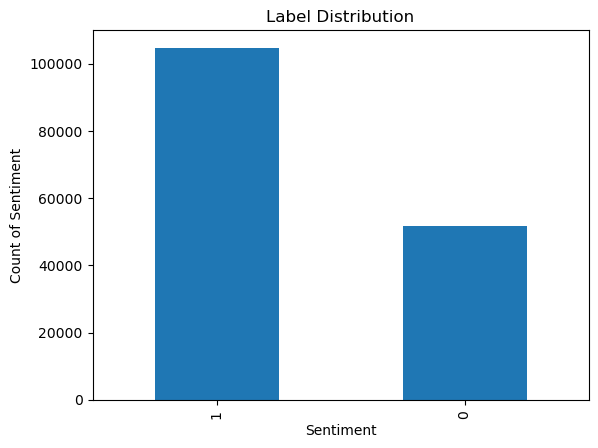

In [27]:
label_count = y_trainset.value_counts().plot(kind = 'bar', title = 'Label Distribution')
label_count.set_ylabel('Count of Sentiment')
label_count.set_xlabel('Sentiment')

## Generating the ML Models

Before sending the data into any model, we first split the train data into training set and test set for further testing. This can be performed using the train test split api. The test data is set to 20 percent of the original data size.

In [28]:
X_train,X_test, y_train, y_test = train_test_split(X_trainset, y_trainset, test_size=0.2, random_state=42)

In [29]:
print("Shape of training set X: ", X_train.shape)
print("Shape of training label y: ",y_train.shape)
print('\n')
print("Shape of test set X: ", X_test.shape)
print("Shape of test label y: ", y_test.shape)

Shape of training set X:  (125048,)
Shape of training label y:  (125048,)


Shape of test set X:  (31263,)
Shape of test label y:  (31263,)


The review is in text format. This needs to be converted into numerical matrix format for ease of calculation. This is done using the CountVectorizer API.

In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_cv = vectorizer.transform(X_train)

# Transform the testing data using the count vectorizer
X_test_cv = vectorizer.transform(X_test)
x_testing_cv = vectorizer.transform(X_testingset)


In [31]:
# tfvectorizer = TfidfVectorizer()
# tfvectorizer.fit(X_train)

# X_train_tfv = tfvectorizer.transform(X_train)

# # Transform the testing data using the same vectorizer
# X_test_tfv = tfvectorizer.transform(X_test)
# x_testing_tfv = tfvectorizer.transform(X_testingset)


To get a measure of the performance of the difference models under consideration, let us note down the different models under consideration and their respective accuracies.

In [32]:
accuracy_count = {}

### Logistic Regressor

Accuracy: 0.8065764641908966


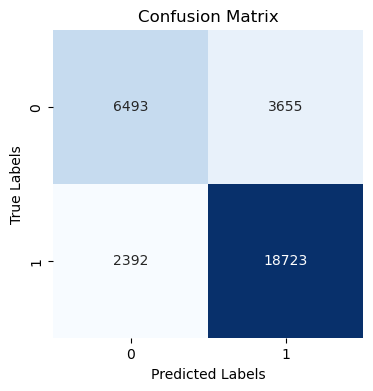

In [33]:
# Train a classifier (e.g., Logistic Regression)
classifier = LogisticRegression(max_iter = 2000, C = 1)
classifier.fit(X_train_cv, y_train)

y_pred = classifier.predict(X_test_cv)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.show()

accuracy_count['LogisticRegression'] = accuracy

### Multinomial Naive Bayes

Best Parameters: {'alpha': 2, 'fit_prior': False, 'force_alpha': True}
Accuracy: 0.8054569299171545


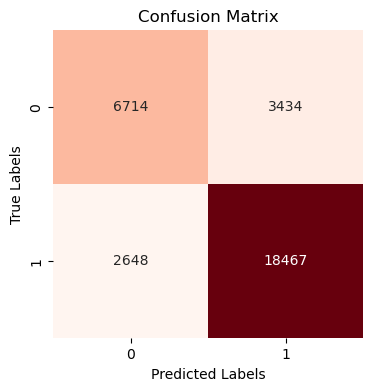

In [34]:
param_grid = {
    'alpha': [0.1,1,2,10], 
    'fit_prior': [True, False],
    'force_alpha': [True, False]
}

# Create a pipeline with CountVectorizer and MultinomialNB
multnb = MultinomialNB()


# Create a GridSearchCV object
grid_search = GridSearchCV(multnb, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_cv, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best classifier
best_classifier = grid_search.best_estimator_


#Predicted Values
y_pred = best_classifier.predict(X_test_cv)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['Multinomial Naive Bayes'] = accuracy

### Naive Bayes Classifier

Best Parameters: {'alpha': 2, 'fit_prior': True, 'force_alpha': True}
Accuracy: 0.8054569299171545


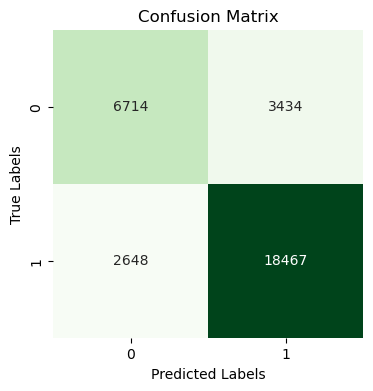

In [35]:
param_grid = {
    'alpha': [0.1,1,2,10], 
    'fit_prior': [True, False],
    'force_alpha': [True, False]
}

# Create a pipeline with CountVectorizer and Complement NB
compmt_classifier = ComplementNB()


# Create a GridSearchCV object
grid_search = GridSearchCV(compmt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_cv, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best classifier
best_classifier = grid_search.best_estimator_


#Predicted Values
y_pred = best_classifier.predict(X_test_cv)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['Complement Naive Bayes'] = accuracy

### SVC Classifier

Accuracy: 0.8096471867703036


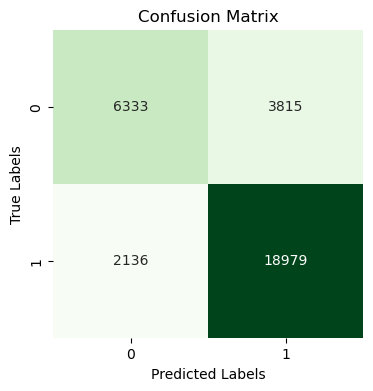

In [36]:
svc_classifier = LinearSVC(C = 0.0409, max_iter = 1500)

svc_classifier.fit(X_train_cv, y_train)

#Predicted Values
y_pred = svc_classifier.predict(X_test_cv)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['Linear SVC'] = accuracy

In [37]:
# param_grid = {
#     'C' : [0.0409],
#     'loss': ['hinge', 'squared_hinge'] ,
#     'multi_class': ['ovr', 'crammer_singer'],
#     'penalty' : ['l1', 'l2']
# }

# svc_classifier = LinearSVC(max_iter = 1500)


# # Create a GridSearchCV object
# grid_search = GridSearchCV(svc_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object on the training data
# grid_search.fit(X_train_cv, y_train)

# # Get the best parameter values
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best classifier
# best_classifier = grid_search.best_estimator_


# #Predicted Values
# y_pred = best_classifier.predict(X_test_cv)

# # Accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# cm = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize=(4, 4))

# # Create a heatmap using seaborn
# sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)

# # Set labels, title, and ticks
# ax.set_xlabel('Predicted Labels')
# ax.set_ylabel('True Labels')
# ax.set_title('Confusion Matrix')



### Random Forest Classifier

Accuracy: 0.6769343952915587


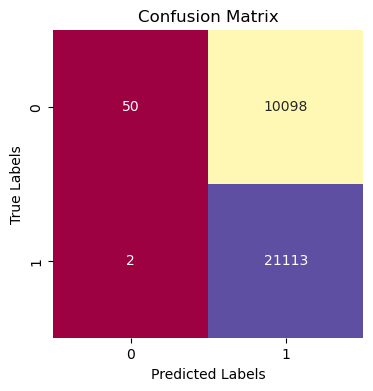

In [38]:
rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=50, min_samples_split = 2, min_samples_leaf =2)

rf_classifier.fit(X_train_cv, y_train)

#Predicted Values
y_pred = rf_classifier.predict(X_test_cv)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['RandomForestClassifier'] = accuracy

### Adaboost Classifier

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7670728976745674


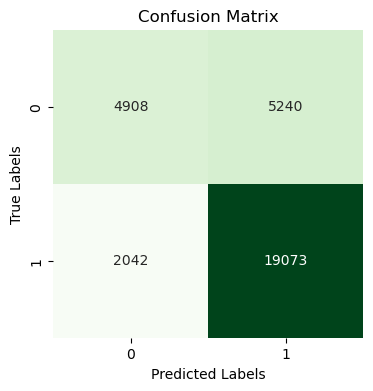

In [39]:
base_estimator = LinearSVC(C = 0.05, max_iter = 1500)
adaboost = AdaBoostClassifier(base_estimator=base_estimator, algorithm = 'SAMME')

adaboost.fit(X_train_cv, y_train)

y_pred = adaboost.predict(X_test_cv)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['AdaBoostClassifier'] = accuracy

### Perceptron

Best Parameters: {'alpha': 0.0001, 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.7502478968749


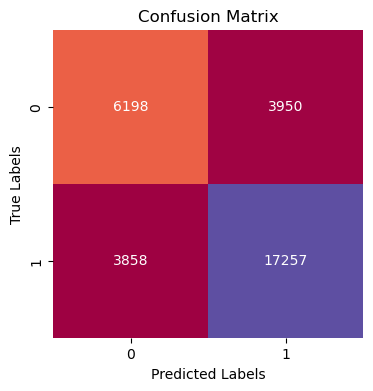

In [40]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 500]
}

perceptron = Perceptron()


# Create a GridSearchCV object
grid_search = GridSearchCV(perceptron, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_cv, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best classifier
best_classifier = grid_search.best_estimator_


# Create a Perceptron classifier

# Train the Perceptron classifier on the training data
perceptron.fit(X_train_cv, y_train)

# Make predictions on the testing data
y_pred = perceptron.predict(X_test_cv)



# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

accuracy_count['Perceptron'] = accuracy

In [41]:
# pca = PCA(n_components=100)
# pca.fit(X_train_cv)

# X_train_pca = pca.transform(X_train_cv)
# X_test_pca = pca.transform(X_test_cv)

# mlp = MLPClassifier()#hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter = 1500)

# mlp.fit(X_train_pca, y_train)

# #Predicted Values
# y_pred = mlp.predict(X_test_pca)

# # Accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# cm = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize=(4, 4))

# # Create a heatmap using seaborn
# sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False, ax=ax)

# # Set labels, title, and ticks
# ax.set_xlabel('Predicted Labels')
# ax.set_ylabel('True Labels')
# ax.set_title('Confusion Matrix')



## Measure the performance of each of the models

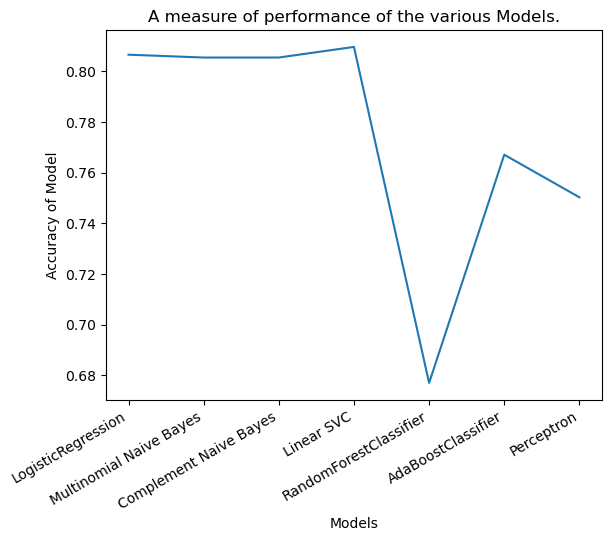

In [42]:

models = list(accuracy_count.keys())
accuracy = list(accuracy_count.values())

sns.lineplot(x = models, y = accuracy)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy of Model')
plt.title('A measure of performance of the various Models.')
plt.show()

We can observe from this that the Linear SVC classifier offers the best accuracy of the list of models used. Therefore, the final prediction of the test set will be based on the **Linear SVC Model**.

## Predict the test set using the Optimal Classifier

In [43]:

y_pred_test = svc_classifier.predict(x_testing_cv)

y_pred_test
replace_dict = {1:'POSITIVE', 0:'NEGATIVE' }
y_predictions = [replace_dict[sentiment] for sentiment in y_pred_test]

submission = pd.DataFrame(y_predictions, columns = ["sentiment"])
submission.insert(loc = 0, column = "id", value = np.arange(len(submission)))


submission.to_csv("submission.csv", index = False)
